# Sale Assurance proof of concept

## Dmitri Tchebotarev

https://github.com/DTchebotarev

dmitri@tchebotarev.com

This notebook contains a work sample using the Shree House Prices dataset. I'll be using this dataset to build up a prototype for Properly's sale assurance. I'll be 

1. Examining the data
2. Creating a model
4. Creating product metrics and analyzing them
3. Refining the model 
4. Analyzing changes to the product the improved model can offer

At the end of this exercise, I'll want to:
- Have a model that predicts the sale price of a house, with a confidence interval
- Use this model to prototype a Sales Assurance type product
- Answer questions such as: How close can the sale assurance price get to the sale price (how attractive is the product for customers?)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # ugly plots
import statsmodels.api as sm # linear regression
from sklearn.ensemble import GradientBoostingRegressor # trees
from sklearn.model_selection import GridSearchCV, train_test_split
from tqdm import tqdm # nice progress bar

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)



# Examining the data

Using the Shree dataset https://www.kaggle.com/shree1992/housedata, first we'll load in the data as a pandas dataframe, and take a cursory look at the data.

In [2]:
try:
    data = pd.read_csv('/kaggle/input/housedata/data.csv')
    data.to_csv('data.csv')
except:
    data = pd.read_csv('data.csv')
data.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated
count,4.600000e+03,4600.000000,4600.000000,4600.000000,4.600000e+03,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000
mean,5.519630e+05,3.400870,2.160815,2139.346957,1.485252e+04,1.512065,0.007174,0.240652,3.451739,1827.265435,312.081522,1970.786304,808.608261
std,5.638347e+05,0.908848,0.783781,963.206916,3.588444e+04,0.538288,0.084404,0.778405,0.677230,862.168977,464.137228,29.731848,979.414536
min,0.000000e+00,0.000000,0.000000,370.000000,6.380000e+02,1.000000,0.000000,0.000000,1.000000,370.000000,0.000000,1900.000000,0.000000
25%,3.228750e+05,3.000000,1.750000,1460.000000,5.000750e+03,1.000000,0.000000,0.000000,3.000000,1190.000000,0.000000,1951.000000,0.000000
50%,4.609435e+05,3.000000,2.250000,1980.000000,7.683000e+03,1.500000,0.000000,0.000000,3.000000,1590.000000,0.000000,1976.000000,0.000000
75%,6.549625e+05,4.000000,2.500000,2620.000000,1.100125e+04,2.000000,0.000000,0.000000,4.000000,2300.000000,610.000000,1997.000000,1999.000000
max,2.659000e+07,9.000000,8.000000,13540.000000,1.074218e+06,3.500000,1.000000,4.000000,5.000000,9410.000000,4820.000000,2014.000000,2014.000000


In [3]:
data.head(3)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.5,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.5,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.0,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA


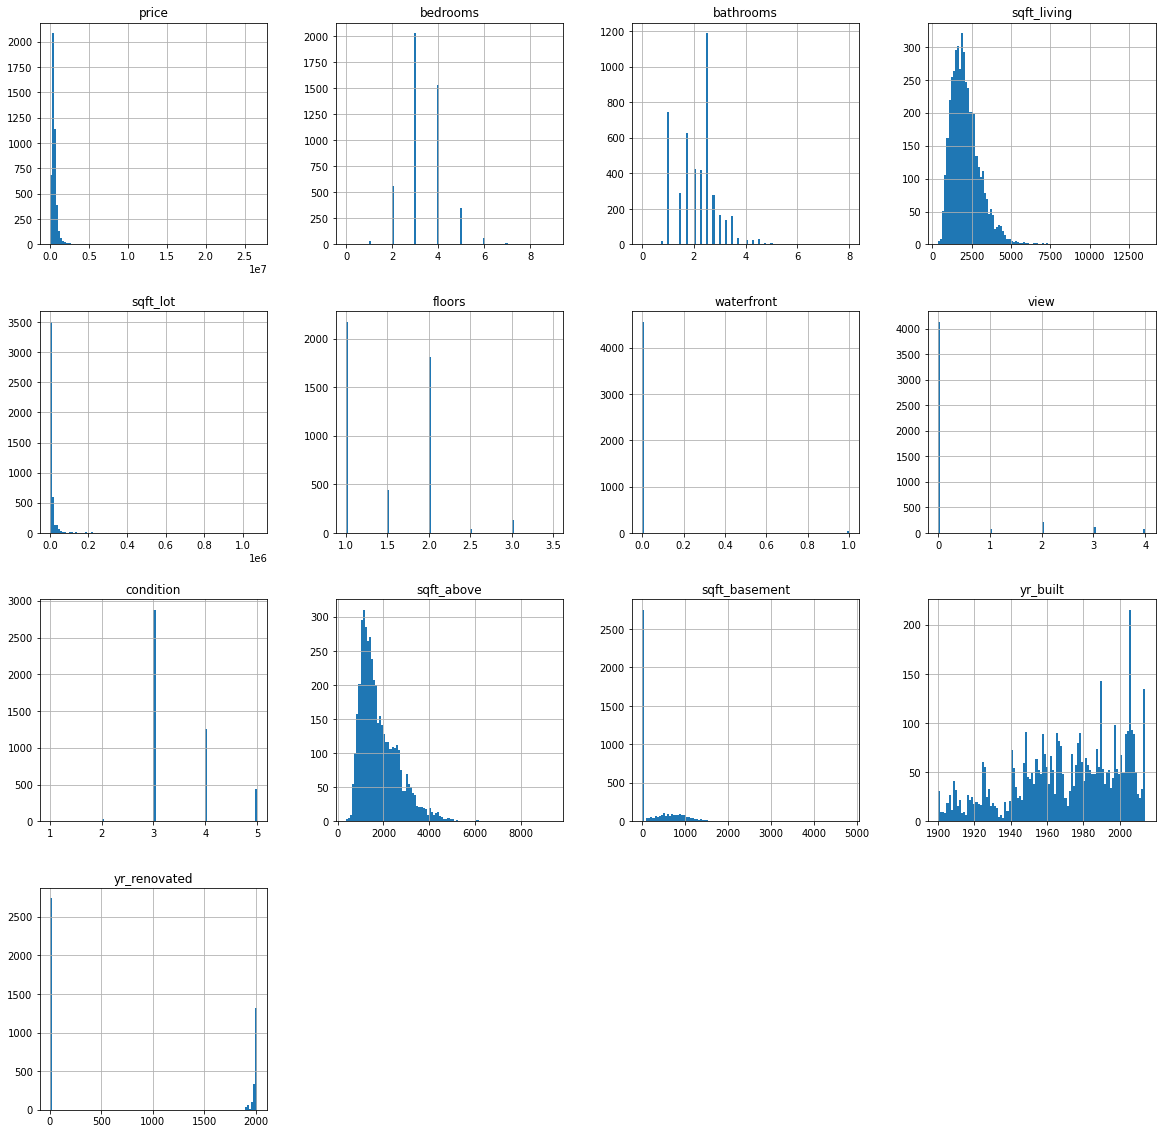

In [4]:
data.hist(figsize = (20,20), bins = 100);

I notice a few things off the get-go, that I'll want to keep in mind when I run the regression:
- There's some real outliers in this dataset. the 75th percentile for price is 650k, but the max is 26.5 M. I don't expect the model to work equally well across all ranges, so I might end up dropping some outliers from the training data.
- There's some missing data, e.g. renovation date. I would hazard a guess that it means the house was never renovated. I might backfill this with the build date. I think it's reasonable to say that when a house is built it starts out as renovated. 
- Some of the data is wrong. There's some 0 values for both bedrooms and bathrooms, which seems weird for a house. There's also some houses with a price of 0, which I strongly doubt is actually the case.
- Living sq ft appears to be basement + above ground, i.e. holds no additional info. I will drop this variable and use basement + above
- price, and square feet are heavily skewed. Some transformations could improve model performance.

NB: given some more time I would validate these thoughts/assumptions more thoroughly


# Creating a model

Since I need predictions for sale prices, I'll need something that works well with continuous outputs, and that can produce a confidence level for the prediction. I will start with a linear regression model. This has a couple advantages:

1. It's an easy model to work with and analyze
2. It's a great baseline to compare a more advanced ML model against
3. It'll work with the 4600 data points we have, whereas a neural net might require more training data
5. It's easy to set a confidence interval, compared to some other ML models

I'm choosing to use the statsmodels implementation. It's more complete than the scikit learn implementationm, at the cost of having a less standardized interface.

Before we jump into creating the model, first let's do the required data transformations that I flagged in the previous section.

In [5]:
# see how many data points there are with missing data
data[(data.bedrooms == 0) | (data.price == 0) | (data.bathrooms == 0)].shape

(51, 18)

It looks like some of the data was miscoded. I'm opting to drop this data from the dataset. I don't want to train on these features, if in production a user tries to enter 0 bedrooms or 0 bathrooms we would want to reject that data at the input validation stage. Thankfully there's not too many of these, and droppping them shouldn't adversely affect the model.

In [6]:
data_cleaned = data[(data.bedrooms > 0)]
data_cleaned = data_cleaned[(data_cleaned.price < data_cleaned.price.quantile(.99)) & (data_cleaned.price > 0)] 

I'm dropping both the 0 prices, but also the top 1% of houses. They are likely outliers, and if a home is that expensive, we would likely not want to offer sale assurance for it anyway

I'm also going to use the zip code as a feature. However, some zip codes don't have enough houses and will be put into the "other" category.

In [7]:
sizes = data_cleaned.groupby('statezip').size()
small_zips = list(sizes.index[sizes < 50])
small_zips_v = data_cleaned.statezip.isin(small_zips)
data_cleaned.loc[small_zips_v, 'statezip'] = 'Other'
data_cleaned.groupby('statezip').size() # check to make sure we still have some zip codes left

statezip
Other       768
WA 98001     66
WA 98004     63
WA 98006    108
WA 98023     93
WA 98027     94
WA 98028     66
WA 98029     87
WA 98031     65
WA 98033     88
WA 98034     98
WA 98038     95
WA 98040     76
WA 98042     97
WA 98045     50
WA 98052    135
WA 98053     96
WA 98056     81
WA 98058     95
WA 98059    106
WA 98065     69
WA 98072     63
WA 98074     94
WA 98075     81
WA 98077     51
WA 98092     83
WA 98103    148
WA 98106     66
WA 98107     57
WA 98112     66
WA 98115    129
WA 98116     64
WA 98117    132
WA 98118     79
WA 98122     66
WA 98125     88
WA 98126     78
WA 98133     93
WA 98136     56
WA 98144     80
WA 98146     53
WA 98155     86
WA 98166     57
WA 98168     65
WA 98177     51
WA 98198     56
WA 98199     65
dtype: int64

In [8]:
data_cleaned.head(10)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,Other,USA
4,2014-05-02 00:00:00,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA
5,2014-05-02 00:00:00,490000.0,2.0,1.00,880,6380,1.0,0,0,3,880,0,1938,1994,522 NE 88th St,Seattle,WA 98115,USA
6,2014-05-02 00:00:00,335000.0,2.0,2.00,1350,2560,1.0,0,0,3,1350,0,1976,0,2616 174th Ave NE,Redmond,WA 98052,USA
7,2014-05-02 00:00:00,482000.0,4.0,2.50,2710,35868,2.0,0,0,3,2710,0,1989,0,23762 SE 253rd Pl,Maple Valley,WA 98038,USA
8,2014-05-02 00:00:00,452500.0,3.0,2.50,2430,88426,1.0,0,0,4,1570,860,1985,0,46611-46625 SE 129th St,North Bend,WA 98045,USA
9,2014-05-02 00:00:00,640000.0,4.0,2.00,1520,6200,1.5,0,0,3,1520,0,1945,2010,6811 55th Ave NE,Seattle,WA 98115,USA
10,2014-05-02 00:00:00,463000.0,3.0,1.75,1710,7320,1.0,0,0,3,1710,0,1948,1994,Burke-Gilman Trail,Lake Forest Park,WA 98155,USA


In [9]:
data_cleaned.shape # check that I didn't lose too many observations

(4503, 18)

In [10]:
# making the target DF:
y = data_cleaned.price
# making the features DF
# start out with the already transformed variables and some ordinal
X = data_cleaned[['sqft_lot', 'sqft_above', 'sqft_basement', 'bedrooms', 'bathrooms', 'yr_built']] # bed/bath could be dummies, but will assume they can be used as cardinal values
# add the categorical and some ordinal variables as dummies
X = pd.concat((X, pd.get_dummies(data = data_cleaned[['waterfront', 'statezip', 'floors', 'view', 'condition']], drop_first = True)), axis = 1) 
# backfill yr_renovated with yr_built if yr_reno = 0
X['yr_renovated'] = data_cleaned.apply(lambda x: x.yr_renovated if x.yr_renovated > 0 else x.yr_built, axis=1)
X.loc[:,'const'] = 1 # add constant term
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42)

In [11]:
X_train.head(5)

,sqft_lot,sqft_above,sqft_basement,bedrooms,bathrooms,yr_built,waterfront,floors,view,condition,statezip_WA 98001,statezip_WA 98004,statezip_WA 98006,statezip_WA 98023,statezip_WA 98027,statezip_WA 98028,statezip_WA 98029,statezip_WA 98031,statezip_WA 98033,statezip_WA 98034,statezip_WA 98038,statezip_WA 98040,statezip_WA 98042,statezip_WA 98045,statezip_WA 98052,statezip_WA 98053,statezip_WA 98056,statezip_WA 98058,statezip_WA 98059,statezip_WA 98065,statezip_WA 98072,statezip_WA 98074,statezip_WA 98075,statezip_WA 98077,statezip_WA 98092,statezip_WA 98103,statezip_WA 98106,statezip_WA 98107,statezip_WA 98112,statezip_WA 98115,statezip_WA 98116,statezip_WA 98117,statezip_WA 98118,statezip_WA 98122,statezip_WA 98125,statezip_WA 98126,statezip_WA 98133,statezip_WA 98136,statezip_WA 98144,statezip_WA 98146,statezip_WA 98155,statezip_WA 98166,statezip_WA 98168,statezip_WA 98177,statezip_WA 98198,statezip_WA 98199,yr_renovated,const
4209,5500,2030,890,4.0,2.50,1957,0,1.0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2000,1
4179,8227,1770,450,3.0,3.25,1929,0,1.5,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1929,1
1432,8187,1060,0,2.0,1.00,1952,0,1.0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1952,1
662,7226,2010,0,4.0,2.50,1995,0,2.0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1995,1
2118,6301,1330,0,3.0,1.75,1998,0,1.0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2006,1


I'm intentionally leaving off a few variables. I might add these later, if I can figure out a way to make them useful.
- date: only spans a few months, likely not too useful
- living space: it's just basement space + above ground space, not useful
- year built/renovated: included as a cardinal value for now, which should have some information, but I can think of potential improvements, perhaps converting to age and adding a quadratic term
- price is included as is, but it is heavily skewed and could be transformed

In [12]:
model = sm.OLS(y_train, X_train).fit(cov_type = 'HC2')
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     98.58
Date:                Wed, 20 Oct 2021   Prob (F-statistic):               0.00
Time:                        23:23:16   Log-Likelihood:                -29996.
No. Observations:                2251   AIC:                         6.011e+04
Df Residuals:                    2193   BIC:                         6.044e+04
Df Model:                          57                                         
Covariance Type:                  HC2                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
sqft_lot             -0.3189      0.098     -3.244      0.001      -0.512      -0.126
sqft_above          192.3489      9.559     20.123      0.000     173.614     211.084
sqft_basement       143.1470     12.949     11.055      0.000     117.768     168.526
bedrooms          -1.767e+04   5301.769     -3.333      0.001   -2.81e+04   -7280.524
bathrooms          4.859e+04   9696.395      5.011      0.000    2.96e+04    6.76e+04
yr_built          -1449.8474    237.245     -6.111      0.000   -1914.839    -984.856
waterfront         1.675e+05   7.86e+04      2.130      0.033    1.34e+04    3.22e+05
floors             1.857e+04   1.04e+04      1.783      0.075   -1847.960     3.9e+04
view               5.532e+04   7755.882      7.132      0.000    4.01e+04    7.05e+04
condition          2.356e+04   6083.115      3.873      0.000    1.16e+04    3.55e+04
statezip_WA 98001 -1.335e+05   1.78e+04     -7.499      0.000   -1.68e+05   -9.86e+04
statezip_WA 98004  5.632e+05   5.58e+04     10.097      0.000    4.54e+05    6.73e+05
statezip_WA 98006  1.464e+05   2.28e+04      6.415      0.000    1.02e+05    1.91e+05
statezip_WA 98023 -1.746e+05   1.79e+04     -9.768      0.000    -2.1e+05    -1.4e+05
statezip_WA 98027  4.237e+04   1.84e+04      2.306      0.021    6360.721    7.84e+04
statezip_WA 98028 -1.681e+04   1.66e+04     -1.011      0.312   -4.94e+04    1.58e+04
statezip_WA 98029  8.067e+04   1.57e+04      5.142      0.000    4.99e+04    1.11e+05
statezip_WA 98031 -1.408e+05   1.52e+04     -9.232      0.000   -1.71e+05   -1.11e+05
statezip_WA 98033  2.105e+05   3.96e+04      5.317      0.000    1.33e+05    2.88e+05
statezip_WA 98034  2.281e+04   1.35e+04      1.687      0.092   -3696.390    4.93e+04
statezip_WA 98038 -1.396e+05   1.57e+04     -8.901      0.000    -1.7e+05   -1.09e+05
statezip_WA 98040  3.467e+05    4.6e+04      7.542      0.000    2.57e+05    4.37e+05
statezip_WA 98042 -1.628e+05   1.63e+04     -9.973      0.000   -1.95e+05   -1.31e+05
statezip_WA 98045 -5.433e+04   2.38e+04     -2.286      0.022   -1.01e+05   -7754.649
statezip_WA 98052  1.282e+05    1.7e+04      7.524      0.000    9.48e+04    1.62e+05
statezip_WA 98053  1.129e+05   2.17e+04      5.212      0.000    7.05e+04    1.55e+05
statezip_WA 98056 -6.726e+04   2.08e+04     -3.227      0.001   -1.08e+05   -2.64e+04
statezip_WA 98058 -1.298e+05   1.68e+04     -7.717      0.000   -1.63e+05   -9.69e+04
statezip_WA 98059 -4.473e+04   2.09e+04     -2.144      0.032   -8.56e+04   -3838.226
statezip_WA 98065     -3e+04   2.59e+04     -1.156      0.248   -8.08e+04    2.09e+04
statezip_WA 98072  4.088e+04   2.55e+04      1.602      0.109   -9118.441    9.09e+04
statezip_WA 98074  6.795e+04    1.8e+04      3.785      0.000    3.28e+04    1.03e+05
statezip_WA 98075  7.643e+04   2.56e+04      2.986      0.003    2.63e+04

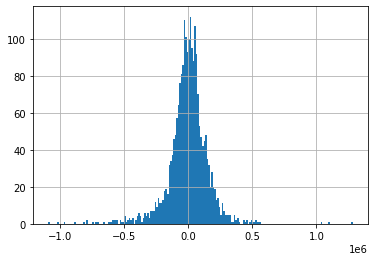

In [13]:
predictions = model.predict(X_test)
errors = predictions - y_test
errors.hist(bins=200);

Looking at the errors, it seems that most of the errors are clustered around 0, which is good. However, there's quite a few outliers, and some errors are quite large. Next let's see how this model could be used to power our Sales Assurance product.

# Metrics and analysis

We could analyze the model via ML metrics, like the RMSE, or an MAE score. However, it's not clear from looking at ML metrics how that translates to a product. 

Since this model is powering a prototype for a product, I'm going to instead compute the _average predicted sale price, as a percentage of the actual sale price_. We would want this number as high as possible, because this makes the product more attractive to customers. I'll also be computing the _average profit per house_, which I define as the commission made from the 5\% buying and selling commission, less any sales assurance payouts. We want this number to be positive. If it's negative, then we would be losing money on average.

We can use different quantiles for our prediction to adjust the level of the predictions while keeping the model the same. If we use a lower quantile, the model predictions will be lower. As a result the revenues will be higher, but the product will be less attractive for customers. Conversely, a higher quantile results in higher predictions, which makes a more attractive product, but increases the potential for having to pay out on sales assurance contracts.

There are some key assumptions that I rely on:

1. All eligible homes will accept price assurance (or a representative portion of the total population). This is likely not the case. A customer can probably evaluate if the sales assurance offer they receive is reasonable or not, and if it's massively underpriced they would likely not accept it, whereas if it's massively overpriced they would see the financial opportunity and accept it. 
2. There are no expenses other than those incurred when the sales assurance price is higher than the market price, which is a simplifying assumption and probably not too much of a reach.

In [14]:
res = model.get_prediction(X_test)
REV_PERCENT = .05 # assume this is revenue commission
def get_prediction_at_quantile(q=.05):
    alpha = q*2
    return [i for i, j in res.conf_int(alpha = alpha)]
def get_stats_for_quantile(q=.05):
    results = get_prediction_at_quantile(q)
    total_rev = sum(y_test*REV_PERCENT)
    total_loss = sum([i for i in results - y_test if i > 0])
#     print(results[0:100])
    return {'quantile': q,
            'total_profit': total_rev - total_loss,
            'total_rev': total_rev,
            'total_loss': total_loss,
            'pred_pct_of_price': sum(results/y_test)/len(results),
            'profit_per_house': (total_rev - total_loss) / len(results)
    }
stats_df = pd.DataFrame([get_stats_for_quantile(q*.001) for q in range(10)])

In [15]:
stats_df

,quantile,total_profit,total_rev,total_loss,pred_pct_of_price,profit_per_house
0,0.000,5.949125e+07,5.949125e+07,0.000000e+00,-inf,26417.074569
1,0.001,4.112060e+06,5.949125e+07,5.537919e+07,0.915807,1825.959169
2,0.002,1.091138e+06,5.949125e+07,5.840011e+07,0.926296,484.519547
3,0.003,-8.560503e+05,5.949125e+07,6.034730e+07,0.932744,-380.128916
4,0.004,-2.354645e+06,5.949125e+07,6.184590e+07,0.937478,-1045.579653
5,0.005,-3.578929e+06,5.949125e+07,6.307018e+07,0.941249,-1589.222670
6,0.006,-4.623227e+06,5.949125e+07,6.411448e+07,0.944399,-2052.942632
7,0.007,-5.538735e+06,5.949125e+07,6.502999e+07,0.947113,-2459.473947
8,0.008,-6.353911e+06,5.949125e+07,6.584516e+07,0.949504,-2821.452473
9,0.009,-7.093848e+06,5.949125e+07,6.658510e+07,0.951646,-3150.021198


Based on the above, it looks like we could use a quantile of 0.02 to generate the price predictions. At this level of confidence, we'd be making on average a slight profit of \\$230 per house sale, and on average offering a sale assurance for 93\% of what the home will eventually sell for. I think this is ok as a baseline level of performance, but we can likely do better.

# Improving the model

Let's try something else. I believe a gradient boosted tree model could offer better performance. My intuition suggests that there might be complex interaction effects. E.g. an additional bedroom might offer more value downtown vs in a suburb. These complex effects would need to be included manually in a linear regression, whereas a gradient boosted tree could uncover that on its own.

In [16]:
X_train.drop('const', axis=1, inplace=True) # don't need a constant for a GB regressor
X_test.drop('const', axis=1, inplace=True)

In [17]:
def find_best_model(q):
    param_grid= {
        'n_estimators':[100, 150],
        'learning_rate': [.05, 0.1],
        'min_samples_leaf': [.1, 1]
    }
    estimator = GradientBoostingRegressor(loss = 'quantile',alpha = q)
    clf = GridSearchCV(
        estimator, param_grid
    )
    clf.fit(X_train, y_train)
    return clf
bm = find_best_model(.35)

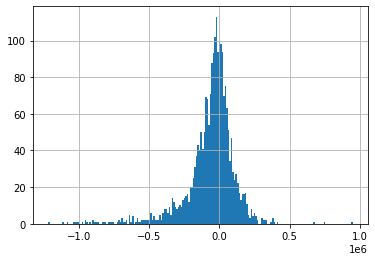

In [18]:
predictions = bm.predict(X_test)
errors = predictions - y_test
errors.hist(bins=200);

In [19]:
REV_PERCENT = .05 # assume this is revenue commission
def get_stats_for_quantile(q=.05):
    bm = find_best_model(q)
    results = bm.predict(X_test)
    total_rev = sum(y_test*REV_PERCENT)
    total_loss = sum([i for i in results - y_test if i > 0])
    return {'quantile': q,
            'total_profit': total_rev - total_loss,
            'total_rev': total_rev,
            'total_loss': total_loss,
            'pred_pct_of_price': sum(results/y_test)/len(results),
            'profit_per_house': (total_rev - total_loss) / len(results)
    }
stats_df = pd.DataFrame([get_stats_for_quantile(q*.01) for q in tqdm(range(30,41), bar_format='{l_bar}{bar:35}{r_bar}{bar:-10b}')])


100%|███████████████████████████████████| 11/11 [03:28<00:00, 18.99s/it]                                                                                                                                                                                                         


In [20]:
stats_df

,quantile,total_profit,total_rev,total_loss,pred_pct_of_price,profit_per_house
0,0.30,7.261926e+06,5.949125e+07,5.222933e+07,0.952030,3224.656280
1,0.31,5.647027e+06,5.949125e+07,5.384422e+07,0.957486,2507.560950
2,0.32,2.754312e+06,5.949125e+07,5.673694e+07,0.967403,1223.051469
3,0.33,-6.930300e+04,5.949125e+07,5.956055e+07,0.974900,-30.773980
4,0.34,-2.086780e+06,5.949125e+07,6.157803e+07,0.980613,-926.634021
5,0.35,-3.264954e+06,5.949125e+07,6.275621e+07,0.986010,-1449.801856
6,0.36,-5.849268e+06,5.949125e+07,6.534052e+07,0.991228,-2597.366039
7,0.37,-1.077706e+07,5.949125e+07,7.026831e+07,1.001500,-4785.550893
8,0.38,-1.186987e+07,5.949125e+07,7.136112e+07,1.007552,-5270.812557
9,0.39,-1.466780e+07,5.949125e+07,7.415906e+07,1.010630,-6513.234856


This is a more promising model. It allows us to offer sale assurance at an average of 97\% of the actual sale price of the house, while still maintaining a positive average profit per house. This is much better than the linear model, which could at best allow us to offer a sale assurance for an average of 93\% of the actual sale price. Having a better estimate allows us to offer a better, more enticing product. Better estimates also reduce the risk of adverse selection, whereby clients who know that the model overpredicted their house's value will be more likely to accept the sale assurance offer.